# Google Hashcode 2019 Final Round: Compiling Google

In [1]:
import numpy as np
import io
import os
import pathlib
import networkx as nx
import matplotlib.pyplot as plt
import statistics
import random

In [2]:
config InlineBackend.figure_format = 'retina'

## Utility Functions

In [3]:
def open_input(filename):
    
    path = str(pathlib.Path().absolute()) + "/dataset/" + filename + ".in"

    # Read file
    input_file = io.open(path, mode='r')
    # read all the lines 
    lines = input_file.readlines()
    input_file.close()

    # Parsing file information
    # save number of file, target and server 
    [num_file,num_target,num_server] = np.fromstring(lines[0], dtype=int, sep=' ')

    # conversion of read lines from list of string to list of lists 
    lines = [i.strip("[]\n").split(" ") for i in lines]

    # blank dicts
    time = {}
    dep = {}
    target = {}

    # build time and dep dicts
    row=1

    while row <= num_file*2:
        # save compilation and replication time
        time.update({lines[row][0] : [lines[row][1], lines[row][2]]})
        row_dep=row+1
        # check file dependencies
        if lines[row_dep][0]== "0":
            # no dependencies
            dep.update({lines[row][0]: []})
        else:
            # save file dependencies
            num_dep=int(lines[row_dep][0])
            dep.update({lines[row][0]: lines[row_dep][-num_dep:]})

        row+=2

    # build target dict     
    row=1+num_file*2

    while row <= num_target+(num_file*2):
        # save deadline and score
        target.update({lines[row][0] : [lines[row][1], lines[row][2]]})
        row+=1;

    # conversion dicts lists from string to int
    time = dict((k,list(map(int,v))) for k,v in time.items())
    target = dict((k,list(map(int,v))) for k,v in target.items())

    # generate file list
    file = list(time.keys())

    return num_file, num_target, num_server, file, time, dep, target

In [4]:
# #creates the matrix of execution sequences
# def create_sequence(num_server, target, dep): 
    
#     # INPUT
#     # num_serv: number of servers
#     # target: dictionary of target's files
#     # dep: dictionary of file's dependencies
    
#     # OUTPUT
#     # matrix: matrix of execution sequences
    
    
#     # number of files target
#     num_target = len(target)
#     # list of target files
#     target_keys = list(target.keys())
#     # declaration of emtpy matrix
#     matrix = []
    
   
#     matrix_dim = min(num_server,num_target)
#     # insert a target file for each matrix' row 
#     for i in range(matrix_dim):
#         row = []
#         row.append(target_keys[i])
#         matrix.append(row)
    
#     # declaration of empty list of nodes. Contains nodes that must be inserted in a matrix' row
#     nodes = []
#     # declaration of empty list of files. Contains files that have already been inserted in matrix
#     file_list = []
    
#     # continues filling the matrix with dependencies of file targets
#     for i in range(matrix_dim):
#         nodes.append(matrix[i][0])
        
#         while len(nodes) != 0:
#             dep_list = dep[nodes[0]]
            
#             for f in dep_list:
#                 # check whether the dependency file is already being compiled on a server or not
#                 if not(f in file_list):
#                     matrix[i].insert(0,f)
#                     file_list.append(f)
#                     nodes.append(f)
                    
#             nodes.pop(0)  
        
#     return matrix

In [5]:
# # creates list of target files that do not generates dependencies
# def find_target(target, dep):
#     no_dep_tar = []
    
#     for key_tar in target:
#         no_dep = True
        
#         for key_dep in dep:
#             if key_tar in dep[key_dep]:
#                 no_dep = False
#                 break
                
#         if no_dep:
#             no_dep_tar.append(key_tar)
#     return no_dep_tar

In [6]:
def build_dep_graph(dep, real_target):
    # Build the dependencies graph
    # ------------------------------------------------------
    # INPUT
    # dep = dependencies of all files
    # real_target = target files with compile time < deadline
    
    # OUTPUT
    # dep_graph = dependencies graph
    # ------------------------------------------------------
    
    # Define a directed graph
    dep_graph = nx.DiGraph()
    
    # Add the nodes of the graph and initialized attributes
    dep_graph.add_nodes_from(list(dep.keys()), target=False, priority=0)
    
    # Add the edges of the graph
    for file, dep_list in dep.items():
        for d in dep_list:
            dep_graph.add_edge(d, file)
    
    # Set target attribute
    for t in real_target:        
        dep_graph.nodes[t]['target'] = True
        # Compute priority dividing score by deadline
        dep_graph.nodes[t]['priority'] = target[t][1]/target[t][0] 
    
    return dep_graph

In [7]:
def place_files(files, server_time, sequence):
    # Assign the given files to the server with minimum time
    # ------------------------------------------------------
    # INPUT
    # files = files to place on a server
    # server_time = estimated execution time on each server
    # sequence = list of files assigned to each server
    
    # OUTPUT
    # sequence
    # ------------------------------------------------------

    # Get the index of the server with the minumum estimated execution time
    min_ind = server_time.index(min(server_time)) 
    
    # Place all the file on the server
    for f in files:
        # update the estimated execution time
        server_time[min_ind] = server_time[min_ind] + time[f][0]
        sequence[min_ind].append(f)

In [8]:
def get_predecessors(graph, source):
    # Compute the predecessors of the given node in the graph
    # -------------------------------------------------------
    # INPUT
    # graph
    # source = node of the graph
    
    # OUTPUT
    # pred = predecessors of the source
    # ------------------------------------------------------
    
    if not graph.has_node(source):
        raise nx.NetworkXError("The node %s is not in the graph." % source)
    pred = list(n for n, d in nx.shortest_path_length(graph, target=source).items())
    pred.remove(source)
    pred.reverse()
    return pred

In [9]:
def compile_greedy(num_server, dep_graph, real_target, technique):
    # Greedy heuristic that build a possible solution
    # ------------------------------------------------------
    # INPUT
    # num_server = number of servers
    # dep_graph = dependencies graph
    # real_target = target files with compile time < deadline

    # OUTPUT
    # sequence = list of files assigned to each server
    # ------------------------------------------------------
    
    # Empty list for estimated execution time on each server
    server_time = [0]*num_server
    sequence = [[] for _ in range(num_server)]

    # Temporary dependencies graph
    temp_graph = dep_graph
  
    i = 0
    toggle = True
    while toggle:
        i = i+1
        # Get all target files with no target in their dependencies list
        potential_target = []
        for t in real_target:
            # check if t is still in the graph
            if t in temp_graph:
                # get the predecessors of the target
                pred = get_predecessors(temp_graph, t)
                # check if t has target in his dependencies list
                no_target = True
                for p in pred:
                    if p in real_target:
                        no_target = False
                        break
                # if t has no target in his dependencies list append t to potential targets
                if no_target:
                    potential_target.append(t)
        
        # check if there are potential targets
        if potential_target:
            toggle = True
            
            # get the target with maximum priority among the potential targets
            max_priority = dep_graph.nodes[potential_target[0]]['priority']
            best_target = potential_target[0]
            
            for t in potential_target:
                if dep_graph.nodes[t]['priority'] > max_priority:
                    max_priority = dep_graph.nodes[t]['priority']
                    best_target = t        
            
            # get the predecessors of the best target
            pred = get_predecessors(temp_graph, best_target)
            
            if pred:
                # check the technique to use comparing median compilation and replication time
                if technique == 1:
                    # Technique 1: assign the target with all his predecessors to the same server 
                    pred.append(best_target)
                    place_files(pred, server_time, sequence)
                    # remove all the placed files
                    temp_graph.remove_nodes_from([n for n in temp_graph if n in set(pred)])
                
                elif technique == 2:
                    # Technique 2: assign predecessors file to different servers
                    for d in dep[best_target]:
                        if d in temp_graph:
                            # compute the predecessors of each file in the target dependencies list
                            pred = get_predecessors(temp_graph, d)
                            pred.append(d)
                            # assign the file with all his predecessors to the same server 
                            place_files(pred, server_time, sequence)
                            # remove all the placed files
                            temp_graph.remove_nodes_from([n for n in temp_graph if n in set(pred)])
                    
                    # place the target and remove it from the graph
                    place_files([best_target], server_time, sequence)
                    temp_graph.remove_node(best_target)
                    
            else:
                # if the target has no predecessors, place the target and remove it from the graph
                place_files([best_target], server_time, sequence)
                temp_graph.remove_node(best_target)
               
        else: 
            # if there are not potential target, end the algorithm
            toggle = False    
            
    return sequence

In [10]:
def build_graph(time, dep, sequence):
    # Build the execution graph
    # -------------------------------------------------
    # INPUT
    # time = times dictionary
    # dep = dependencies dictionary
    # sequence = list of files assigned to each server

    # OUTPUT
    # execution_graph = execution graph
    # -------------------------------------------------
    
    # Define the directed graph of the files
    execution_graph = nx.DiGraph()

    # Add the nodes of the graph
    for i,s in enumerate(sequence):
        execution_graph.add_nodes_from(s, server=i+1)

    # Add the edges of the graph
    for s in sequence:    
        # add an edge between files on the same server
        for i in range(len(s)-1):
            w = time[s[i]][0]
            execution_graph.add_edge(s[i], s[i+1], weight=w, n_weight=-w, color="black")
        # add dipendencies edges for each file on a server
        for i in range(len(s)):       
            dep_files = dep[s[i]]
            # check that the files has dipendencies
            if dep_files: 
                for f in dep_files:
                    # check that the file is on another server
                    if f not in s:
                        w = time[f][0] + time[f][1]
                        execution_graph.add_edge(f, s[i], weight=w, n_weight=-w, color="black")

    # Add two fake nodes
    execution_graph.add_node("s", server=-1)
    execution_graph.add_node("t", server=-1)

    for node in list(execution_graph.nodes):
        if (node!="s" and node!="t"):
            # if node doesn't have in-edges, add edge s -> node
            if not execution_graph.in_edges(node):
                execution_graph.add_edge("s", node, weight=0, n_weight=0, color="black")
            # if node doesn't have out-edges, add edge node -> t
            elif not execution_graph.out_edges(node):
                w = time[node][0]
                execution_graph.add_edge(node, "t", weight=w, n_weight=-w, color="black")    
    
    return execution_graph

In [11]:
def get_longest_path(graph):
    # Get the longest path using negative weights and Bellman-Ford algorithm
    # ------------------------------------------------------------------------
    # INPUT
    # graph = execution graph

    # OUTPUT
    # graph = execution graph 
    # distance = execution times
    # ------------------------------------------------------------------------
    
    distance, path = nx.algorithms.shortest_paths.weighted.single_source_bellman_ford(graph, "s", weight="n_weight")
    # change the color of the edge on the path
    for key,value in path.items():
        if len(value)>1:
            for i in range(len(value)-1):
                graph[value[i]][value[i+1]]["color"] = "red"
    
    return graph, distance

In [12]:
def get_score(distance, target, time):
    # Compute the score of the solution
    # --------------------------------------------
    # INPUT
    # distance = execution times
    # real_target = target files with compile time < deadline
    # time = times dictionary
    
    # OUTPUT
    # score = score of the solution
    # good_target = target with score > 0
    # bad_target = target with score = 0
    # --------------------------------------------

    # Compute the score of the solution
    score = 0
    good_target=[]
    bad_target=[]
    
    for file in target:
        # check if the file target is in the given solution
        if file in distance:
            d = target[file][0]
            x = -distance[file]+time[file][0]
            # check if the file is compiled before the deadline
            if x<=d:
                g = target[file][1]
                score = score + (d-x + g)
                good_target.append(file)
            else:
                bad_target.append(file)
            
    return score, good_target, bad_target

In [13]:
def compile_improve(num_server, file, time, dep, target, max_iter):
    # Improvement heuristic that try to improve the solution given by compile_greedy
    # ------------------------------------------------------------------------------
    # INPUT
    # num_server = number of servers
    # time = times dictionary
    # dep = dependencies dictionary
    # target = targets list

    # OUTPUT
    # best_graph = best execution graph
    # best_score = best score obtained    
    # best_sequence = best solution given by compile_greedy
    # best_distance = best execution times
    # ------------------------------------------------------------------------------
    
    # Temporary target
    temp_target = target
        
    best_score = 0
    best_sequence = [[]]    
    best_graph = nx.DiGraph()
    best_distance = {}
    
    i = 0
    while True:
        
        # Remove target files with compilation time > deadline
        real_target = [t for t in temp_target if target[t][0]>time[t][0]]
        
        # Build dependencies graph
        dep_graph = build_dep_graph(dep, real_target)
        
        # Compute compilation and replication time for each non-target file 
        t_comp = []
        t_rep = []
        for f in file:
            if f not in real_target:
                t_comp.append(time[f][0])
                t_rep.append(time[f][1])

        # compute the median of times
        t_comp_med = statistics.median(t_comp)
        t_rep_med = statistics.median(t_rep) 
        
        # check the technique to use comparing median compilation and replication time
        if t_rep_med > t_comp_med:
            technique = 1
        else:
            technique = 2
        
        # Get possible execution sequences
        sequence = compile_greedy(num_server, dep_graph, real_target, technique)
        
        # Build execution graph
        execution_graph = build_graph(time, dep, sequence)

        # Compute execution times by tracing the longest path
        execution_graph, distance = get_longest_path(execution_graph)
        # Compute the score of the solution
        score, good_target, bad_target = get_score(distance, target, time)
        
        print(score, len(good_target), len(bad_target))    
                
        # if the last score is better then best score
        if(score>=best_score):
            # save the solution as best solution
            i = 0
            best_score = score
            best_sequence = sequence
            best_graph = execution_graph
            best_distance = distance
        else:
            i = i+1
            
        # if not bad target or too not-improving iteration, end the algorithm
        if not bad_target or i>max_iter:
            break
        
#         #randomic selection of tabu target
#         random.seed()
#         target_tabu = random.randint(0,len(bad_target)-1)
#         #print("dimensione ",len(bad_target)," indice ",target_tabu)
#         temp_target.pop(bad_target[target_tabu])

        # get execution times of bad target
        target_distance = {t:d for t,d in distance.items() if t in bad_target}
        # remove the bad target with minimum initial time
        target_tabu = max(target_distance, key=target_distance.get)
        temp_target.pop(target_tabu)
        
    return best_graph, best_score, best_sequence, best_distance

In [14]:
def write_file(distance, graph, filename):
    # Write the output file
    # -------------------------------------------------------------------------
    # INPUT
    # distance: dictionary of distances for current execution sequence
    # graph: graph of current execution sequence
    
    # OUTPUT
    # creates/overwrites file in path "./output/submission_file.txt"
    # -------------------------------------------------------------------------

    # convert distances in positive values
    distance = dict((k,abs(v)) for k,v in distance.items())
    #convert distance dictionary to list
    distance_list = sorted(distance.items(), key=lambda x: x[1])
    
    # checking wheater output's folder exists
    path_dir=str(pathlib.Path().absolute())+ "/output"
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)  
    
    # opening file
    path = path_dir + '/' + filename + '_submission_file.txt'
    file_object = open(path, 'w')
    
    # writing file
    file_object.write(str(len(distance_list)-2)+ '\n')
#     print(str(len(distance_list)-2))
    
    for i in distance_list:
        if(i[0] != 's' and i[0] != 't'):
            file = i[0]
            time = i[1]
            server = graph.nodes[file]['server']
            file_object.write(file + " " + str(server) + '\n')
#             print(file + " " + str(time) + " " + str(server))

    file_object.close()

In [15]:
def draw_graph(graph, sequence):   
    
    # Draw the given graph
    fig = plt.figure(figsize=(10,6))
    ax = plt.axes()
    
    # graph layout
    pos = nx.planar_layout(graph)
    
    # draw nodes
    cmap = plt.get_cmap('Pastel1')
    # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html <----- visit here for others color maps
    colors = [cmap(i) for i in np.linspace(0, 1, len(sequence)+1)]
    for i,server in enumerate(sequence):
        nx.draw_networkx_nodes(graph, pos, ax=ax, nodelist=server, node_color=[colors[i]], alpha=1, edgecolors="black")
    nx.draw_networkx_nodes(graph, pos, ax=ax, nodelist=["s","t"], node_color=[colors[len(sequence)]], alpha=1, edgecolors="black")
    nx.draw_networkx_labels(graph, pos, ax=ax);
    
    # draw edges
    color = nx.get_edge_attributes(graph,'color')
    nx.draw_networkx_edges(graph, pos, ax=ax, width=1.0, alpha=0.8, edge_color=color.values())
    edge_labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph, pos, ax=ax, edge_labels=edge_labels, label_pos=0.5)

    plt.show()
    
    return graph

In [16]:
def draw_dep_graph(dep_graph):
    
    # Draw the dependencies graph
    fig = plt.figure(figsize=(10,6))
    ax = plt.axes()
    # graph layout
    pos = nx.planar_layout(dep_graph)
    # draw nodes
    cmap = plt.get_cmap('Pastel1')
    nx.draw_networkx_nodes(dep_graph, pos, ax=ax, nodelist=[n for n in dep_graph if n not in target], node_color=[cmap(1)], alpha=1, edgecolors="black")
    nx.draw_networkx_nodes(dep_graph, pos, ax=ax, nodelist=[n for n in dep_graph if n in target], node_color=[cmap(0)], alpha=1, edgecolors="black")
    nx.draw_networkx_labels(dep_graph, pos, ax=ax);
    # draw edges
    nx.draw_networkx_edges(dep_graph, pos, ax=ax, width=1.0, alpha=0.8, edge_color="black")

    plt.show()

In [17]:
# def place_files2(pred, server_time, sequence, num_server, predecessori):
#     t=pred.pop()
#     num_files=[0]*num_server
#     for (i,s) in enumerate(sequence):
#         for f in s:
#             if f in predecessori[t]:
#                 num_files[i]= num_files[i]+1
# #                 print("in comune" + f)
# #     print(t, num_files)
#     pred.append(t)
       
#     max_value = max(num_files)
#     if max_value == 0:
#         max_ind = server_time.index(min(server_time))
#     else:
#         max_ind=num_files.index(max(num_files))
       
#     for file in pred:
#         server_time[max_ind] = server_time[max_ind] + time[file][0]
#         sequence[max_ind].append(file)

# Main Algorithm

Score
Dataset 	 Best Score
0 0 3
25 1 1
25 1 0
a_example 	 25
992418 50 0
b_narrow 	 992418
1063647 5 15
1084257 5 14
1109863 5 13
1128129 5 12
1191158 8 8
1232221 14 1
1238841 14 0
c_urgent 	 1238841
3242 2 97
2378 1 97
4060 3 94
3146 2 94
3423 2 93
5846 3 91
5846 3 90
5846 3 89
5846 3 88
5846 3 87
5846 3 86
5846 3 85
10499 4 83
8218 4 82
8218 4 81
11695 5 79
12224 5 78
15054 6 76
17511 7 74
11615 6 74
16800 7 72
19331 7 71
19331 7 70
23308 8 68
23308 8 67
23308 8 66
23308 8 65
23308 8 64
41028 9 62
41028 9 61
41028 9 60
41028 9 59
44366 10 57
48860 11 55
48860 11 54
48860 11 53
48860 11 52
48860 11 51
48860 11 50
48860 11 49
48860 11 48
48860 11 47
48860 11 46
48860 11 45
48860 11 44
48860 11 43
48860 11 42
48860 11 41
48860 11 40
48860 11 39
48860 11 38
64576 12 36
64576 12 35
64576 12 34
64576 12 33
64576 12 32
64576 12 31
64576 12 30
64576 12 29
65877 13 27
64576 12 27
64576 12 26
64576 12 25
78568 13 23
78568 13 22
78568 13 21
78568 13 20
78568 13 19
78568 13 18
78568 13 17
78568

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


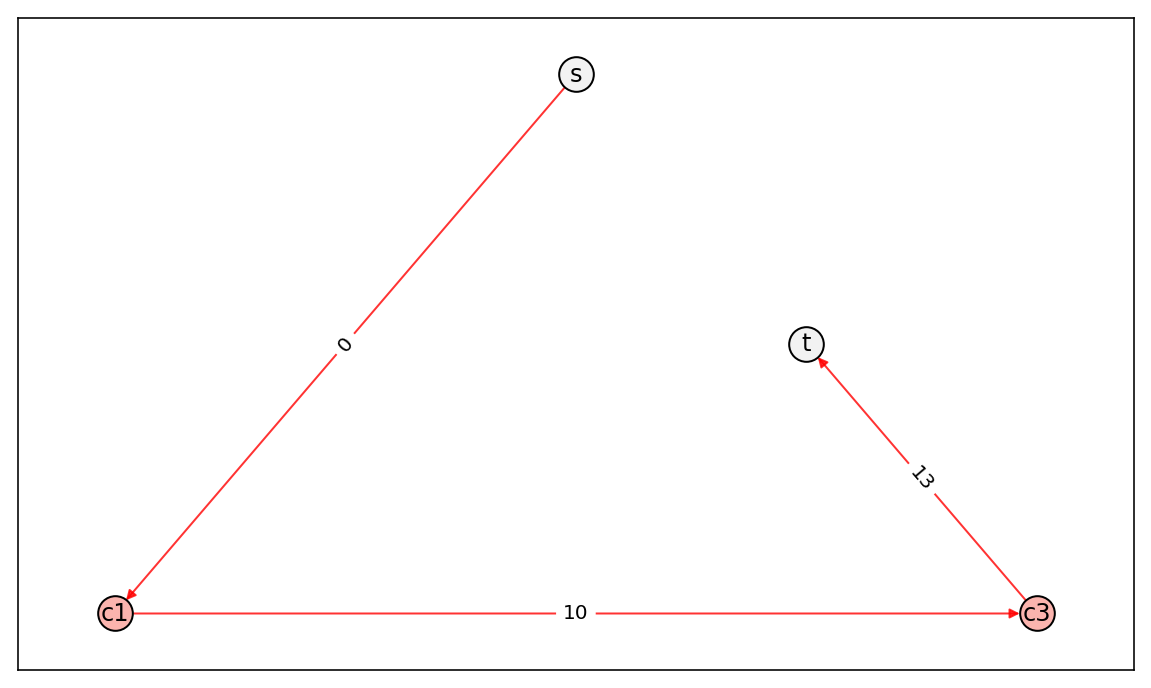

In [18]:
dataset = ["a_example","b_narrow","c_urgent","d_typical","e_intriguing","f_big"]
max_iter = 5
tot_score = 0

print("Score")
print("Dataset \t Best Score")
for d in dataset:
    num_file, num_target, num_server, file, time, dep, target = open_input(d)

    best_graph, best_score, best_sequence, best_distance = compile_improve(num_server, file, time, dep, target, max_iter)
    
    write_file(best_distance, best_graph, d)
    
    tot_score = tot_score + best_score

    print(d,'\t',best_score)    
    
    if(d == "a_example"):
        a_graph = best_graph  
        a_sequence = best_sequence
        
print("Total Score:", tot_score)
draw_graph(a_graph, a_sequence)

# abbiamo messo in compile_improve un >= al posto di un >, così continua ad iterare pure se lo score è uguale
# così prendiamo più punti su d ma ci mette tanto tempo anche con max_iter = 5
# in alternativa si potrebbe mettere di nuovo > e aumentare max_iter (più di 10)

# Total Score: 2379484

In [19]:
# # num_file, num_target, num_server, file, time, dep, target = open_input("a_example.in")
# # num_file, num_target, num_server, file, time, dep, target = open_input("b_narrow.in")
# num_file, num_target, num_server, file, time, dep, target = open_input("c_urgent.in")
# # num_file, num_target, num_server, file, time, dep, target = open_input("d_typical.in")
# # num_file, num_target, num_server, file, time, dep, target = open_input("e_intriguing.in")
# # num_file, num_target, num_server, file, time, dep, target = open_input("f_big.in")
# compile_tabu(target)

In [20]:
# real_target = [t for t in target if target[t][0]>time[t][0]]

# somma = 0
# for rt in real_target:
#     somma = somma + target[rt][1]
    
# print(somma)

In [21]:
# dep_graph = build_dep_graph(dep, target)
# # draw_dep_graph(dep_graph)

In [22]:
# server_time=[0]*num_server
# sequence = [[] for _ in range(num_server)]
# compile_greedy(dep_graph, sequence, server_time, real_target)

In [23]:
# graph = build_graph(time, dep, sequence)
# # graph = draw_graph(graph)

In [24]:
# graph, distance, path = get_longest_path(graph)
# # graph = draw_graph(graph)

In [25]:
# score = get_score(distance, target, time)
# score

In [26]:
# file

# DOUBTS
* Ci sono dei file non target che non servono a nessun file target:
* Ci sono dei target che hanno tempo di compilazione maggiore della deadline

In [27]:
# print(len(target))
# real_target = [t for t in target if target[t][0]>time[t][0]]
# print(len(real_target))